In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

              ImageId                                      EncodedPixels
121461  8611cfb15.jpg                                                NaN
30778   224192aec.jpg  323442 2 324210 6 324978 8 325745 9 326513 9 3...
80321   58b2d43a7.jpg                                                NaN
119371  83bb2690c.jpg                                                NaN
19670   15c50a864.jpg                                                NaN


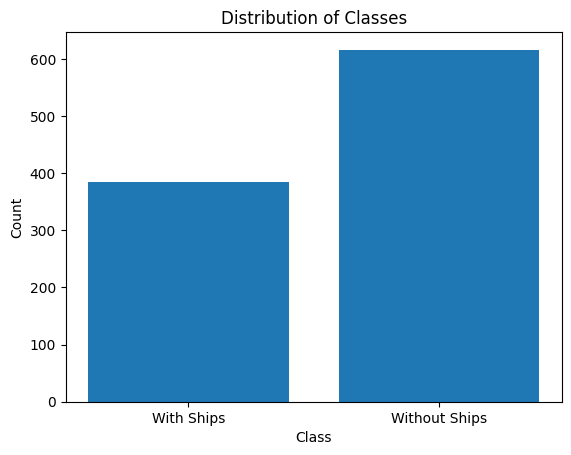

In [29]:
# Завантаження та відображення деяких прикладів даних
train_df = pd.read_csv("train_ship_segmentations_v2.csv")
train_df = train_df.sample(n=1000, random_state=42)
print(train_df.head())

# Візуалізація розподілу класів
ship_count = train_df['EncodedPixels'].notna().sum()
no_ship_count = len(train_df) - ship_count

plt.bar(['With Ships', 'Without Ships'], [ship_count, no_ship_count])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.show()

In [30]:
# Фільтрація зображень, на яких є кораблі
ships = train_df['EncodedPixels'].notna()
train_df = train_df[ships]
print(train_df.head())

              ImageId                                      EncodedPixels
30778   224192aec.jpg  323442 2 324210 6 324978 8 325745 9 326513 9 3...
210688  e8dc87183.jpg  132095 1 132862 3 133629 4 134397 4 135164 5 1...
113877  7d9b0c7ab.jpg  470356 1 471124 3 471891 6 472659 8 473426 11 ...
198994  dc24a20e1.jpg  9691 5 10451 13 11211 21 11975 25 12743 26 135...
32288   23d9ae03d.jpg  535625 1 536391 3 537157 6 537923 8 538690 10 ...


Визначення та компіляції моделі U-Net

In [31]:
import tensorflow as tf
from tensorflow.keras import layers

In [32]:
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    concat1 = layers.Concatenate()([conv2, up1])
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.Concatenate()([conv1, up2])
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    # Create the model
    model = tf.keras.Model(inputs, outputs)
    return model

In [33]:
# Ім'я зображення та розмітка
train_image_dir = 'train_images/'
train_df['ImageId'] = train_df['ImageId'].apply(lambda x: os.path.join(train_image_dir, x))

In [34]:
from sklearn.model_selection import train_test_split

# Розділення на тренувальний та валідаційний набори
train_files, val_files = train_test_split(train_df['ImageId'], test_size=0.1, random_state=42)

In [35]:
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 345, Validation samples: 39


Генератор даних

In [36]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

In [37]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, files, batch_size=16, image_size=(256, 256), shuffle=True, train_df=None):
        self.files = files
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.train_df = train_df

    def __len__(self):
        return int(np.floor(len(self.files) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.files[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_files)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            self.files = shuffle(self.files)

    def __data_generation(self, batch_files):
        X = np.zeros((self.batch_size, *self.image_size, 3))
        y = np.zeros((self.batch_size, *self.image_size, 1))

        for i, file in enumerate(batch_files):
            img = cv2.imread(file)
            mask = self.__masks_from_file(file)

            X[i,] = cv2.resize(img, self.image_size)
            y[i,] = np.expand_dims(cv2.resize(mask, self.image_size), axis=-1) / 255.0

        return X, y

    def __masks_from_file(self, file):
        masks = np.zeros((768, 768, 1), dtype=np.uint8)  # Змінено форму маски

        img_masks = self.train_df.loc[self.train_df['ImageId'] == file, 'EncodedPixels'].tolist()
        for mask in img_masks:
            if pd.notna(mask):
                masks[:, :, 0] += self.__rle_decode(mask)  # Використовуємо перший канал маски

        return masks

    def __rle_decode(self, mask_rle):
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(768 * 768, dtype=np.uint8)
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        return img.reshape(768, 768, order='F')

In [38]:
# Розмірність вхідних зображень
input_shape = (256, 256, 3)

In [39]:
# Створення та компіляція моделі
model = unet_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Створення генераторів даних
train_generator = DataGenerator(train_files, batch_size=16, train_df=train_df)
val_generator = DataGenerator(val_files, batch_size=16, train_df=train_df)

In [41]:
# Навчання моделі
model.fit(train_generator, epochs=5, validation_data=val_generator)

Epoch 1/5


21/21 [==============================] - 440s 21s/step - loss: 0.0180 - accuracy: 0.9958 - val_loss: 3.5591e-04 - val_accuracy: 0.9980
Epoch 2/5
21/21 [==============================] - 376s 18s/step - loss: 0.0022 - accuracy: 0.9972 - val_loss: 6.2380e-04 - val_accuracy: 0.9981
Epoch 3/5
21/21 [==============================] - 374s 18s/step - loss: 6.6976e-04 - accuracy: 0.9973 - val_loss: 3.2146e-04 - val_accuracy: 0.9986
Epoch 4/5
21/21 [==============================] - 365s 17s/step - loss: 4.9529e-04 - accuracy: 0.9972 - val_loss: 2.3998e-04 - val_accuracy: 0.9981
Epoch 5/5
21/21 [==============================] - 327s 15s/step - loss: 3.5665e-04 - accuracy: 0.9972 - val_loss: 1.8681e-04 - val_accuracy: 0.9982


In [42]:
# Інференс для тестових зображень
random_row = train_df.sample(random_state=42)
image_id = random_row['ImageId'].values[0]
image_path = f'{image_id}'
test_image = cv2.imread(image_path)
test_image_resized = cv2.resize(test_image, (256, 256)) / 255.0
test_image_resized = np.expand_dims(test_image_resized, axis=0)

In [43]:
if test_image_resized.dtype != np.uint8:
    test_image_resized = (test_image_resized * 255).astype(np.uint8)

In [44]:
# Отримання сегментаційної маски
predictions = model.predict(test_image_resized)

1/1 [==============================] - 0s 448ms/step


In [45]:
if predictions.dtype != np.uint8:
    predictions = (predictions * 255).astype(np.uint8)

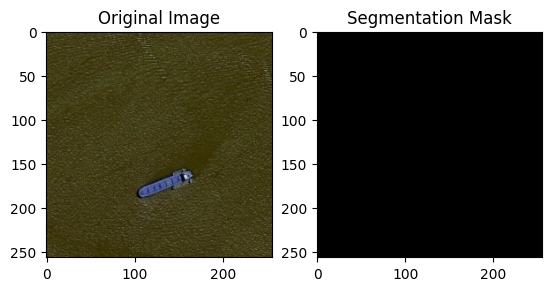

In [46]:
# Відображення оригінального зображення та сегментаційної маски поруч
plt.subplot(1, 2, 1)
plt.imshow(test_image_resized[0])
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predictions[0, :, :, 0], cmap='gray')
plt.title('Segmentation Mask')
plt.show()